# Data exploration
This notebook contains some tests about data import and some data viz tools

In [1]:
DATA_FOLDER = './data/'
MOVIES_FOLDER = DATA_FOLDER + 'movies_summaries/'
PLOT_SUMMARY_FOLDER = DATA_FOLDER + 'corenlp_plot_summaries'
KAGGLE_FOLDER = DATA_FOLDER + 'kaggle/'

REPORT_FOLDER = './gen/reports/'
ETHNICITY_FILE = './gen/ethnicities.tsv'

CHARACTERS_FILE = MOVIES_FOLDER + 'character.metadata.tsv'
MOVIES_FILE = MOVIES_FOLDER + 'movie.metadata.tsv'
PLOT_SUMMARIES_FILE = MOVIES_FOLDER + 'plot_summaries.txt'
TROPES_FILE = MOVIES_FOLDER + 'tvtropes.clusters.txt'

KAGGLE_FILE = KAGGLE_FOLDER + 'movies_metadata.csv'

# country to study in this notebook
TARGET_COUNTRIES = ['United States of America']

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

# from pandas_profiling import ProfileReport
%matplotlib inline

from data_wrangling_tools import *

# Import dataset
Import the "merged dataset" which contains, for each movie, the movie metadata and the actors which plays in it.  
This dataset is generated by loading and merging the characters, the CMU movies and the Kaggle movies.  
Note that the Kaggle movies are not used to add movies that are missing in the CMU movies dataset, but to add missing information 
about the movies present in the CMU movies dataset, such as IMDB ratings, missing box office and budget.

In [3]:
# merged_df = generate_clean_df(CHARACTERS_FILE, ETHNICITY_FILE, MOVIES_FILE)
merged_df = generate_clean_df_with_kaggle(CHARACTERS_FILE, ETHNICITY_FILE, MOVIES_FILE, KAGGLE_FILE)

# Keep only us movies
merged_df = filter_with_countries(merged_df, TARGET_COUNTRIES, 'any')

print("Number of entries: {}".format(len(merged_df)))
merged_df.head()

Number of entries: 244471


,wiki_movie_id,freebase_movie_id,movie_name,release_date,box_office_revenue,runtime,genres,languages,countries,char_name,a_name,a_gender,a_ethnicity,a_dob,a_age_at_release,a_height
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"[Thriller, Science Fiction, Horror, Adventure,...",[English Language],[United States of America],Akooshay,Wanda De Jesus,F,NaN,1958-08-26,42.0,1.620
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"[Thriller, Science Fiction, Horror, Adventure,...",[English Language],[United States of America],Lieutenant Melanie Ballard,Natasha Henstridge,F,NaN,1974-08-15,27.0,1.780
2,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"[Thriller, Science Fiction, Horror, Adventure,...",[English Language],[United States of America],Desolation Williams,Ice Cube,M,NaN,1969-06-15,32.0,1.727
3,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"[Thriller, Science Fiction, Horror, Adventure,...",[English Language],[United States of America],Sgt Jericho Butler,Jason Statham,M,NaN,1967-09-12,33.0,1.750
4,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"[Thriller, Science Fiction, Horror, Adventure,...",[English Language],[United States of America],Bashira Kincaid,Clea DuVall,F,NaN,1977-09-25,23.0,1.650


# Import movies dataset
In this section, we import the CMU movies dataset and the Kaggle movies dataset, then merge them together.  
We create this dataset which contains only movies information and don't use the merged dataset (with movies and characters) because it allows easier analysis on movies.

In [4]:
pretty_display = lambda lst: ', '.join(lst)

In [5]:
movies_cmu = load_movies(MOVIES_FILE)
movies_cmu = clean_unknowns(movies_cmu)
movies_cmu = clean_jsons(movies_cmu)

movies_kaggle = load_kaggle(KAGGLE_FILE)
movies = merge_movies_kaggle(movies_cmu, movies_kaggle)

# keep only US movies
movies = filter_with_countries(movies, TARGET_COUNTRIES, mode='any')

print("Number of movies from {}: {}".format(pretty_display(TARGET_COUNTRIES), len(movies)))

movies = movies[movies['box_office_revenue'].notna()]
print("Number of movies with box office revenue from {}: {}".format(pretty_display(TARGET_COUNTRIES), len(movies[movies['box_office_revenue'].notna()])))
print("Number of movies with budget from {}: {}".format(pretty_display(TARGET_COUNTRIES), len(movies[movies['budget'].notna()])))

movies.head()

Number of movies from United States of America: 34431
Number of movies with box office revenue from United States of America: 7704
Number of movies with budget from United States of America: 3846


,wiki_movie_id,freebase_movie_id,name,release_date,box_office_revenue,runtime,languages,countries,genres,budget,vote_average,vote_count
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",28000000.0,4.8,299.0
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",2000000.0,4.8,6.0
17,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,[English Language],[United States of America],"[Children's/Family, Musical, Fantasy, Comedy, ...",6000000.0,7.4,1217.0
21,612710,/m/02wjqm,New Rose Hotel,1999-10-01,21521.0,92.0,[English Language],[United States of America],"[Thriller, Science Fiction, Future noir, Indie...",NaN,NaN,NaN
29,156558,/m/014k4y,Baby Boy,2001-06-27,29381649.0,123.0,[English Language],[United States of America],"[Crime Fiction, Drama, Coming of age]",16000000.0,7.3,57.0


### Ensure "trustness" of the Kaggle dataset
Because the CMU dataset comes from the CMU and was provided for the project, we define it as trustable.  
However, before using the Kaggle dataset, we need to make sure that it is trustable to. To do so, we'll merge the CMU and Kaggle datasets and compare, 
for each movie which have box office revenue information, whether the information is the same on both datasets or not. If it's
the case, the Kaggle movies dataset can be considered as trustable.

In [6]:
df_trust = pd.merge(movies_cmu, movies_kaggle, left_on=[movies_cmu['name'], movies_cmu['release_date'].dt.year], 
                    right_on=[movies_kaggle['original_title'], movies_kaggle['release_date'].dt.year], how='left')
df_trust = df_trust.rename({'release_date_x': 'release_date', 'revenue':'box_office_revenue_kaggle'}, axis=1)
df_trust = df_trust.drop(columns=['original_title', 'key_0', 'key_1', 'release_date_y'])

# select only the rows where the box office revenue is known
df_trust = df_trust[(df_trust['box_office_revenue'].notna()) & (df_trust['box_office_revenue_kaggle'].notna())]

df_trust['box_office_revenue'] = df_trust['box_office_revenue'].astype(float)
df_trust['box_office_revenue_kaggle'] = df_trust['box_office_revenue'].astype(float)

# compare all values
is_same = np.allclose(df_trust['box_office_revenue'].to_numpy(), df_trust['box_office_revenue_kaggle'].to_numpy())

print("Are the values from Kaggle and the values from the movies dataset are the same? {}".format(is_same))

Are the values from Kaggle and the values from the movies dataset are the same? True


# Box office analysis
This section show the trends between the evolution of the box office revenue and other movies features.  Our goal here is to find and eplain
those trends.

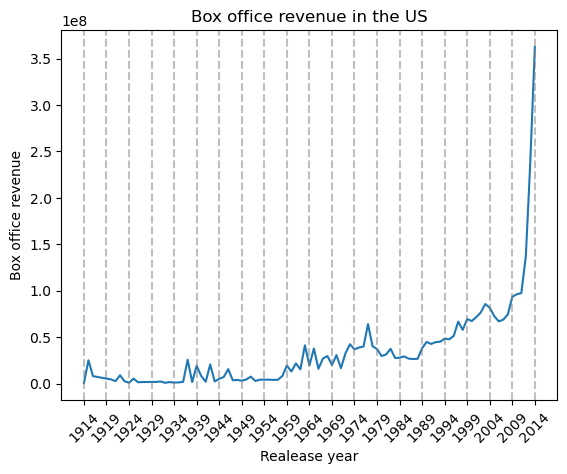

In [78]:
box_office_year = movies.groupby(movies['release_date'].dt.year)['box_office_revenue'].mean().sort_index().plot(kind='line')


box_office_year.plot(legend=False)

plt.title('Box office revenue in the US')
plt.xlabel('Realease year')
plt.ylabel('Box office revenue')

# plt.grid(axis='y', color='grey', linestyle='--', alpha=0.5)
for i in range(1914, 2015, 5):
    plt.axvline(i, color='grey', linestyle='--', alpha=0.5)

plt.xticks(np.arange(1914, 2015, 5), rotation=45)

plt.show()

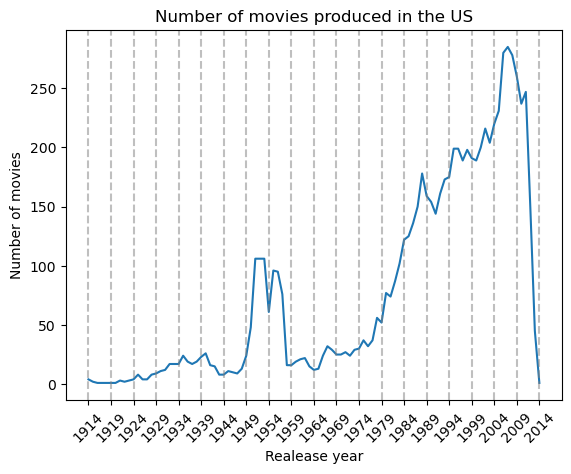

In [80]:
# plot the distribution of the number of movies produced each year
nb_movies_year = movies['release_date'].dt.year.value_counts().sort_index()


nb_movies_year.plot(legend=False)

plt.title('Number of movies produced in the US')
plt.xlabel('Realease year')
plt.ylabel('Number of movies')

# plt.grid(axis='y', color='grey', linestyle='--', alpha=0.5)
for i in range(1914, 2015, 5):
    plt.axvline(i, color='grey', linestyle='--', alpha=0.5)

plt.xticks(np.arange(1914, 2015, 5), rotation=45)

plt.show()

In [12]:
print("Top 10 movies with the highest box office revenue")
movies.sort_values(by='box_office_revenue', ascending=False)[['name', 'box_office_revenue', 'release_date']].head(10)

Top 10 movies with the highest box office revenue


,name,box_office_revenue,release_date
23713,Avatar,2.782275e+09,2009-12-10
22265,Titanic,2.185372e+09,1997-11-01
28205,The Avengers,1.511758e+09,2012-04-11
30293,Harry Potter and the Deathly Hallows – Part 2,1.328111e+09,2011-07-07
37620,Iron Man 3,1.215440e+09,2013-04-24
18653,Transformers: Dark of the Moon,1.123747e+09,2011-06-23
80959,The Lord of the Rings: The Return of the King,1.119930e+09,2003-12-17
78490,Skyfall,1.108561e+09,2012-10-23
54744,The Dark Knight Rises,1.078009e+09,2012-07-16
2754,Pirates of the Caribbean: Dead Man's Chest,1.065660e+09,2006-06-24


## Display most represented ethnicities in movies over the whole dataset

ValueError: min() arg is an empty sequence

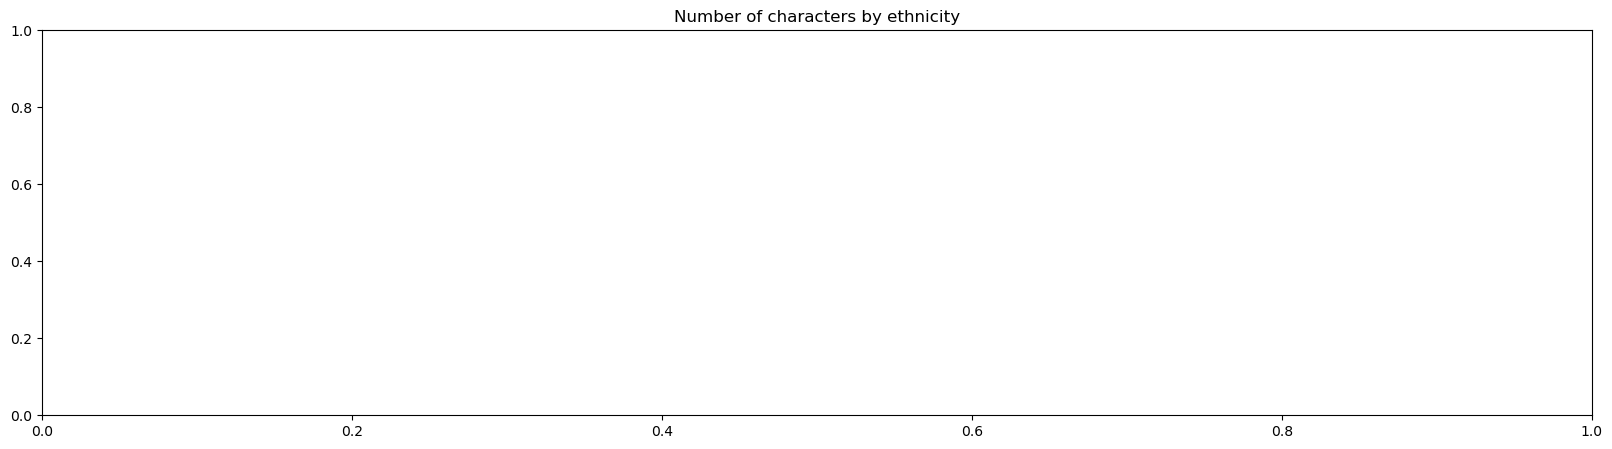

In [9]:
# plot the number of characters of each ethnicity
ethnicity_count = merged_df['a_ethnicity'].value_counts()
ethnicity_count = ethnicity_count[ethnicity_count > 100]

fig, ax = plt.subplots(figsize=(20, 5))
plt.title('Number of characters by ethnicity') 
sns.barplot(x=ethnicity_count.index, y=ethnicity_count, color='lightblue', ax=ax)
# sns.countplot(x=ethnicity_count, color='lightblue', ax=ax)
ax.set_xlabel('Ethnicity')
plt.xticks(rotation=90)
plt.grid(axis='y') #{'major', 'minor', 'both'}
plt.show()

In [ ]:
# count instances of ethnicities for each year
char_ethnicity = merged_df[~merged_df['a_ethnicity'].isna()]

# from https://stackoverflow.com/questions/17764619/pandas-dataframe-group-year-index-by-decade
ethnicity_count = char_ethnicity.groupby([char_ethnicity['release_date'].dt.year // 10 * 10, char_ethnicity['a_ethnicity']]).count()[['wiki_movie_id']]

# gen a "pretty" and usable dataset
ethnicity_count = ethnicity_count.rename(columns={'wiki_movie_id': 'count'})
ethnicity_count = ethnicity_count.reset_index() # level=1
ethnicity_count = ethnicity_count.rename(columns={'release_date': 'm_release_decade'})
ethnicity_count['m_release_decade'] = ethnicity_count['m_release_decade'].astype(int)
ethnicity_count.head()

In [ ]:
# get k most represented ethnicites for each decade
top_k = 10
decades = ethnicity_count['m_release_decade'].unique()

fig, ax = plt.subplots(2, 6, figsize=(20, 10), sharey=True)
ax = ax.flatten()
colors = {}

for i, decade in enumerate(decades[1:]):
    # get top k ethnicites
    df_top_k = ethnicity_count[ethnicity_count['m_release_decade'] == decade].sort_values(by='count', ascending=False).head(top_k)

    # percentage of the top k
    total = df_top_k['count'].sum()
    df_top_k['percentage'] = df_top_k['count'].apply(lambda x: x / total * 100)
    
    for ethnicity in df_top_k['a_ethnicity'].values:
        if ethnicity not in colors:
            colors[ethnicity] = sns.color_palette(n_colors=40)[len(colors)-1]

    # plot distribution
    sns.barplot(x=df_top_k['a_ethnicity'], y=df_top_k['percentage'], ax=ax[i], palette=[colors[ethnicity] for ethnicity in df_top_k['a_ethnicity'].values])

    ax[i].set_title('{}s'.format(int(decade)))
    ax[i].set_xlabel('Ethnicity')
    ax[i].set_xlabel('Percentage')

    # before legend
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90) 

fig.suptitle("Ethnicity representation in movies over the decades")
plt.tight_layout()
plt.show()

# Men/women ratio analysis

In [ ]:
# At the moment, set the ratio to one if the denominator is zero
def compute_men_women_ratio(x):
    genders = x['a_gender']
    nb_actors = x['a_name'].count()
    nb_male = genders[genders == 'M'].count()
    nb_female = genders[genders == 'F'].count()
    nb_nan_gender = genders.isna().sum()

    nb_known_gender = nb_known_gender=nb_male+nb_female
    m_f_ratio = nb_male / nb_female if nb_female > 0 else 1 if nb_male > 0 else 0
    m_ratio = nb_male / nb_known_gender if nb_known_gender > 0 else 0
    f_ratio = nb_female / nb_known_gender  if nb_known_gender > 0 else 0
    nan_ratio = nb_nan_gender / x.shape[0]

    return pd.Series(index=['nb_actors', 'nb_men', 'nb_female', 'nb_nan_gender', 'm_ratio', 'f_ratio', 'M_F_ratio', 'nan_ratio'], data=[nb_actors, nb_male, nb_female, nb_nan_gender, m_ratio, f_ratio, m_f_ratio, nan_ratio])


df_gender = merged_df.groupby('wiki_movie_id').apply(compute_men_women_ratio)

df_gender['nb_actors'] = df_gender['nb_actors'].astype(int)
df_gender['nb_men'] = df_gender['nb_men'].astype(int)
df_gender['nb_female'] = df_gender['nb_female'].astype(int)
df_gender['nb_nan_gender'] = df_gender['nb_nan_gender'].astype(int)
df_gender

In [ ]:
# get the info of only one movie
df_gender = pd.merge(left=merged_df[['wiki_movie_id', 'release_date']], right=df_gender, how='inner', left_on='wiki_movie_id', right_index=True)
df_gender = df_gender.drop_duplicates('wiki_movie_id')
df_gender['m_release_decade'] = df_gender['release_date'].dt.year // 10 * 10
df_gender
# df2['m_release_decade'].isna().sum()

In [ ]:
# ratio over the whole dataset
print("Male / Female ratio over the whole dataset:", merged_df[merged_df['a_gender'] == 'M'].shape[0] / merged_df[merged_df['a_gender'] == 'F'].shape[0])
print("Nan ratio over the whole dataset:", merged_df[merged_df['a_gender'].isna()].shape[0] / merged_df.shape[0])

In [ ]:
# mean gender ratio with matching paires
print("Male / Female ratio: :", df_gender['M_F_ratio'].mean())
print("Nan ratio: over bthe whole dataset:", df_gender['nan_ratio'].mean())

In [ ]:
decades = np.sort(df_gender['m_release_decade'].unique())
decades = decades[~np.isnan(decades)]

fig, ax = plt.subplots(2, 7, figsize=(12, 7), sharey=True, sharex=True)
ax = ax.flatten()

for i, decade in enumerate(decades):
    df_decade = df_gender[df_gender['m_release_decade'] == decade]
    
    x = ['M', 'F', 'Nan']
    y = [df_decade['m_ratio'].mean()*100, df_decade['f_ratio'].mean()*100, df_decade['nan_ratio'].mean()*100]

    # plot distribution
    sns.barplot(x=x, y=y, ax=ax[i])

    ax[i].set_title('{}s'.format(int(decade)))

    if i/7 >= 1:
        ax[i].set_xlabel('Gender')

    if i%7 == 0:
        ax[i].set_ylabel('Percentage')

    # before legend
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90) 

fig.suptitle("Evolution of actors gender over the decades")
plt.tight_layout()
plt.show()



In [ ]:
decades = np.sort(df_gender['m_release_decade'].unique())
decades = decades[~np.isnan(decades)]

gender_dict = {}
for i, decade in enumerate(decades):
    df_decade = df_gender[df_gender['m_release_decade'] == decade]
    
    gender_dict[decade] = {
        'M': df_decade['m_ratio'].mean()*100,
        'F': df_decade['f_ratio'].mean()*100
        # 'Nan': df_decade['nan_ratio'].mean()*100
        }

gender_ratio_df = pd.DataFrame(gender_dict)
gender_ratio_df.columns = ['{}s'.format(int(col)) for col in gender_ratio_df.columns]
gender_ratio_df = gender_ratio_df.T
gender_ratio_df.head()

In [ ]:
# pivot table to have one row per gender
plot_df = gender_ratio_df.reset_index()
plot_df = plot_df.rename(columns={'index': 'decade'})
plot_df = plot_df.melt(id_vars='decade', value_vars=['M', 'F'])
plot_df = plot_df.rename(columns={'variable': 'gender', 'value': 'ratio'})

# tmp_df
sns.barplot(data=plot_df, x='decade', y='ratio', hue='gender')
plt.title('Gender ratio evolution over the decades')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# Age analysis

In [ ]:
age_df = merged_df.copy()
# here, we suppose that negative ages are just a mistake
age_df['a_age_at_release'] = age_df['a_age_at_release'].abs()
age_df['age_decade_at_release'] = age_df['a_age_at_release'] // 10 * 10
age_df['m_release_decade'] = age_df['release_date'].dt.year // 10 * 10

# age decades
age_decades = age_df['age_decade_at_release'].value_counts().drop([960.0, 7890.0, 930.0]).index
age_decades = np.sort(age_decades)
age_decades

In [ ]:
# Here, we put the 70s+ together
age_df['age_decade_at_release'] = age_df['age_decade_at_release'].replace(to_replace=[80.,  90., 100.], value=70.)
age_decades = age_decades[:-3]

In [ ]:
decades = np.sort(age_df['m_release_decade'].unique())
decades = decades[~np.isnan(decades)]

fig, ax = plt.subplots(2, 6, figsize=(12, 7), sharey=True, sharex=True)
ax = ax.flatten()

for i, decade in enumerate(decades[3:]):
    # get top k ethnicites
    df_decade = age_df[age_df['m_release_decade'] == decade]
    df_decade = df_decade[~df_decade['age_decade_at_release'].isna()]

    x = []
    y = []
    for age_decade in age_decades:
        if age_decade == 70:
            x.append('70+')
        else:
            x.append('{}s'.format(int(age_decade)))
        y.append(df_decade[df_decade['age_decade_at_release'] == age_decade].shape[0] / df_decade.shape[0] * 100)

    # plot distribution
    sns.barplot(x=x, y=y, ax=ax[i], palette='tab10')

    ax[i].set_title('{}s'.format(int(decade)))

    if i/7 >= 1:
        ax[i].set_xlabel('Age decade')

    if i%7 == 0:
        ax[i].set_ylabel('Percentage')

    # before legend
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90) 

plt.suptitle("Evolution of actors age over the decades")
plt.tight_layout()
plt.show()

In [ ]:
age_decades_dict = {}

for i, decade in enumerate(decades[3:]):
    # get top k ethnicites
    df_decade = age_df[age_df['m_release_decade'] == decade]
    df_decade = df_decade[~df_decade['age_decade_at_release'].isna()]
    
    row = {}
    for age_decade in age_decades:
        if age_decade == 70:
            col_name = '70s+'
        else:
            col_name = '{}s'.format(int(age_decade))

        if col_name in row:
            row[col_name].update(df_decade[df_decade['age_decade_at_release'] == age_decade].shape[0] / df_decade.shape[0] * 100)
        else:
            row[col_name] =  df_decade[df_decade['age_decade_at_release'] == age_decade].shape[0] / df_decade.shape[0] * 100

    age_decades_dict[decade] = row

In [ ]:
# pd.DataFrame(index='decage', columns=['{}s'.format(age_decade) for age_decade in age_decades])
age_decades_df = pd.DataFrame(age_decades_dict)
age_decades_df.columns = ['{}s'.format(int(col)) for col in age_decades_df.columns]
age_decades_df = age_decades_df.T
age_decades_df.columns = ['0-9 y.o.', '10-19 y.o.', '20-29 y.o.', '30-39 y.o.', '40-49 y.o.', '50-59 y.o.', '60-69 y.o.', '70+ y.o.']

In [ ]:
# Potentially interesting: area, bar, pie (but for each of them independently)
# age_decades_df.plot(kind='bar', stacked=True)
age_decades_df.plot(kind='bar', stacked=True)

plt.xticks(rotation=90)
plt.xlabel('Decade')
plt.ylabel('Percentage')
plt.title('Actor age distribution over the decades')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=45)
plt.show()